In [1]:
import h5py
import torch
import torch.nn as nn
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import skfuzzy as fuzz
from tempfile import TemporaryFile
from scipy.io import loadmat
from torch.utils.data import DataLoader, TensorDataset

import config
import utils

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
rows = [['550', '568']] # , ['5100','5109']
rowss = '550_568'
snr = 0

In [4]:
#load .mat file
[H_true_train, H_true_val], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = utils.load_data(config.outer_file_path, rows, config.device, snr)


# For H_linear

In [5]:
# Normalization
H_linear_train_min = H_linear_train.min()
H_linear_train_max = H_linear_train.max()
H_true_train_min = H_true_train.min()
H_true_train_max = H_true_train.max()

H_linear_train_normd = (H_linear_train - H_linear_train_min)/ (H_linear_train_max - H_linear_train_min)
H_true_train_nomrd   = (H_true_train - H_true_train_min)/ (H_true_train_max - H_true_train_min)

H_linear_val_normd   = (H_linear_val - H_linear_train_min)/ (H_linear_train_max - H_linear_train_min)
H_true_val_normd     = (H_true_val - H_true_train_min)/ (H_true_train_max - H_true_train_min)
# for evaluation, output of model(valData) will be de-normalized and compared with valLabels

print(H_linear_val_normd.shape)
print(H_linear_train_normd.shape)

torch.Size([367, 2, 612, 14])
torch.Size([3072, 2, 612, 14])


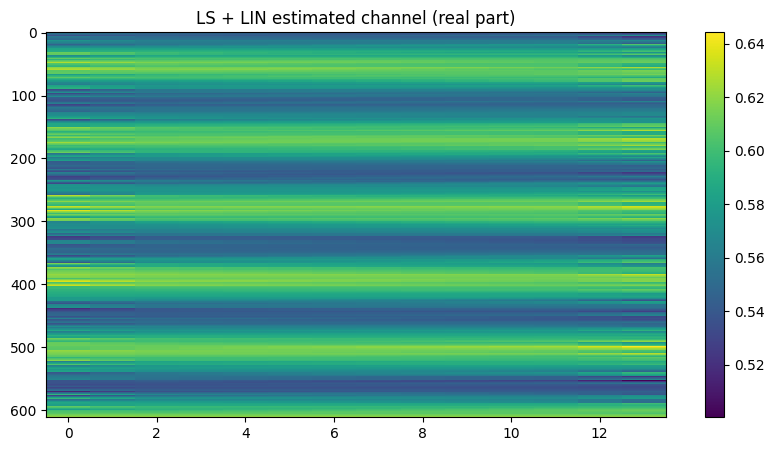

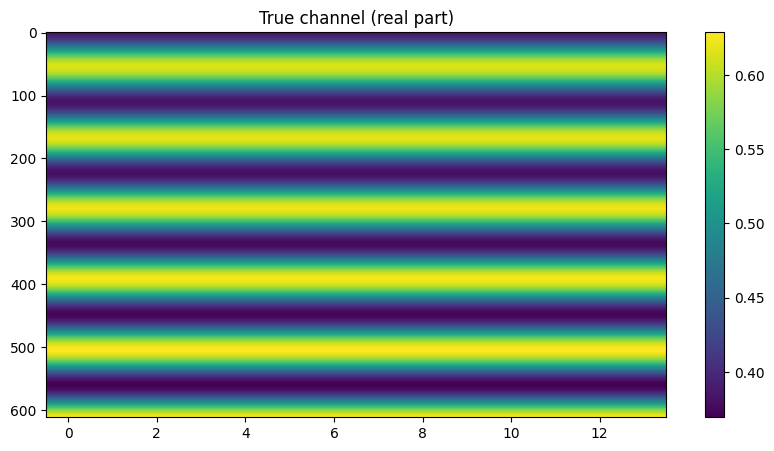

In [6]:
plot = 1
if plot:
    H_temp = H_linear_train_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('LS + LIN estimated channel (real part)')
    plt.show()

    H_temp = H_true_train_nomrd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('True channel (real part)')
    plt.show()

In [7]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((H_linear_train_normd[:,0,:,:], H_linear_train_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((H_true_train_nomrd[:,0,:,:], H_true_train_nomrd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)

trainData_normd.shape

torch.Size([6144, 1, 612, 14])

In [8]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [6144, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(H_linear_val_normd, H_true_val_normd)  # [367, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [29]:
generator = utils.Generator(in_channel=1)   # in_channel=1 to estimate real and imag parts separately,
                                            # default: in_channel=2 to estimate real and imag parts at the same time
discriminator = utils.Discriminator(in_channel=1)

epoc = 0 # flag
load_saved_model = 0
if load_saved_model:
    # modify the directory
    epoc = 30
    #
    generator_load_path = os.path.join(config.FILE_PATH, 'model/static', 'GAN_'+str(snr)+'dB_epoch_'+str(epoc)+'_generator_'+rowss+'.pth')
    discriminator_load_path = os.path.join(config.FILE_PATH, 'model/static', 'GAN_'+str(snr)+'dB_epoch_'+str(epoc)+'_discriminator_'+rowss+'.pth')
    variable_load_path = os.path.join(config.FILE_PATH, 'model/static', 'GAN_'+str(snr)+'dB_epoch_'+str(epoc)+'_variable_'+rowss+'.pth')
    # load the models
    generator.load_state_dict(torch.load(generator_load_path))
    discriminator.load_state_dict(torch.load(discriminator_load_path))
    var_state = torch.load(variable_load_path)

generator = generator.to(config.device)
discriminator = discriminator.to(config.device)

gen_opt = 'Adam'
gen_lr = 2e-4
gen_betas=(0.5,0.999)
dis_opt = 'RMSprop'
dis_lr = 2e-5

generator_optimizer = torch.optim.Adam(params= generator.parameters(), lr=2e-4, betas=(0.5, 0.999)) # 2e-4
discriminator_optimizer = torch.optim.RMSprop(params=discriminator.parameters(), lr=2e-5)           # 2e-5

In [30]:
NUM_EPOCHS = 500

if load_saved_model:
    gen_loss_track = var_state['gen_loss_track']
    disc_loss_track = var_state['disc_loss_track']
    gen_val_loss_track = var_state['gen_val_loss_track']
else: 
    gen_loss_track  = []    # BCE loss in training
    disc_loss_track = []    # BCE loss in training
    gen_val_loss_track = [] # MSE _ compare estimated and true channels
    
H_GAN_val = torch.empty_like(H_true_val_normd)
start_time = datetime.datetime.now()
criterion = nn.MSELoss()

for epoch in range(NUM_EPOCHS):
    generator.train()
    discriminator.train()
    running_gen_loss  = 0.0
    running_disc_loss = 0.0
    if (epoch == NUM_EPOCHS-1):
            i = 0
    print("-----\nEPOCH:", epoch)        
    # for bi, (target, input_image) in enumerate(load_image_train(file_path)):
    for bi, (input_image, target) in enumerate(train_loader):
        # input_image == H_inter == Nsamples x 2 x subcs x symb
        # target      == H_Real  == Nsamples x 2 x subcs x symb x 2 x ant
        elapsed_time = datetime.datetime.now() - start_time
        gen_loss, disc_loss = utils.train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer)
        running_gen_loss += gen_loss
        running_disc_loss += disc_loss
        
    avg_train_gen_loss = running_gen_loss / len(train_loader)
    avg_train_disc_loss = running_disc_loss / len(train_loader)
    gen_loss_track.append(avg_train_gen_loss)
    disc_loss_track.append(avg_train_disc_loss)
    print('Generate Loss (BCE Loss in training): ', avg_train_gen_loss)
    print('Discriminate Loss(BCE Loss in training): ', avg_train_disc_loss)
    
    generator.eval()
    running_gen_val_loss  = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = generator(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_gen_val_loss += val_loss_real.item()
            
            val_outputs_imag = generator(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_gen_val_loss += val_loss_imag.item()

            # save the estimated channel at the last epoch 
            # need i because we loop over batch_size
            if (epoch == NUM_EPOCHS-1): 
                H_GAN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_GAN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
    
    # MSE of estimated and true channels            
    avg_gen_val_loss = running_gen_val_loss/ (len(val_inputs)*2) # divided by 2 because real and imag parts 
        
    gen_val_loss_track.append(avg_gen_val_loss)
    
    print('MSE of estimated and true channels (normalized): ', avg_gen_val_loss)
            
    # if epoch == epochs-1:
    #     nmse_epoch = TemporaryFile()
    #     nm.cpu()
    #     np.save(nmse_epoch, nm)


-----
EPOCH: 0
Generate Loss (BCE Loss in training):  0.5575100065519413
Discriminate Loss(BCE Loss in training):  0.7541478797793388
MSE of estimated and true channels (normalized):  0.4049854000409444
-----
EPOCH: 1
Generate Loss (BCE Loss in training):  0.5556781819711129
Discriminate Loss(BCE Loss in training):  0.7548170033842325
MSE of estimated and true channels (normalized):  0.3679815143346786
-----
EPOCH: 2
Generate Loss (BCE Loss in training):  0.5536238383501768
Discriminate Loss(BCE Loss in training):  0.7530697397887707
MSE of estimated and true channels (normalized):  0.40345319410165154
-----
EPOCH: 3
Generate Loss (BCE Loss in training):  0.5478932947541276
Discriminate Loss(BCE Loss in training):  0.7497865591819087
MSE of estimated and true channels (normalized):  0.38901382784048716
-----
EPOCH: 4
Generate Loss (BCE Loss in training):  0.547383944503963
Discriminate Loss(BCE Loss in training):  0.7499081548303366
MSE of estimated and true channels (normalized):  0.3

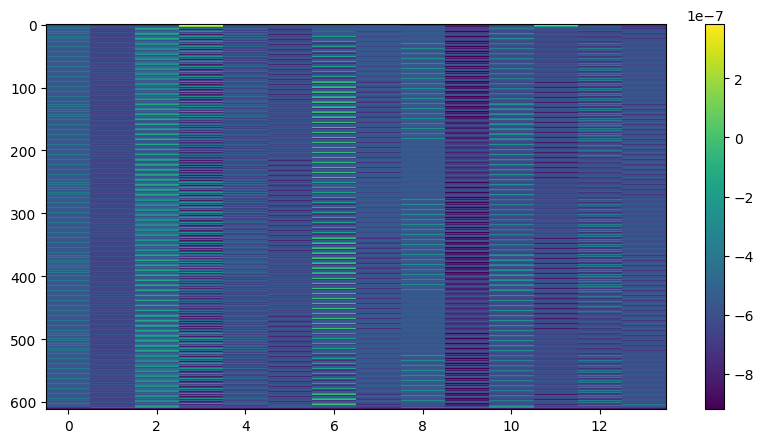

In [56]:
# Linear interpolated channel
H_test = H_GAN_val * (H_true_train_max - H_true_train_min) + H_true_train_min
H_test= H_test.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_test[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [60]:
epoc = epoc + NUM_EPOCHS
save_folder = os.path.join(config.FILE_PATH, 'model/static')
generator_save_path = os.path.join(save_folder, 'GAN_LI_'+str(snr)+'dB_epoch_'+str(epoc)+'_generator_'+rowss+'.pth')
discriminator_save_path = os.path.join(save_folder, 'GAN_LI_'+str(snr)+'dB_epoch_'+str(epoc)+'_discriminator_'+rowss+'.pth')
variable_save_path = os.path.join(save_folder, 'GAN_LI_'+str(snr)+'dB_epoch_'+str(epoc)+'_variable_'+rowss+'.pth')

# Save the models' state dictionaries to the specified paths
torch.save(generator.state_dict(), generator_save_path)
torch.save(discriminator.state_dict(), discriminator_save_path)
torch.save({'H_GAN_val': H_test, 'H_true_val':H_true_val, 'gen_val_loss_track': gen_val_loss_track, 'disc_loss_track': disc_loss_track, 'gen_loss_track':gen_loss_track}, variable_save_path)
            # estimated channel after denormalized                        
                                # true channel before normalized

In [36]:
# save to .mat file
def find_incremental_filename(directory, base_name):
    # List all files in the directory
    files = os.listdir(directory)
    
    # Filter out files that match the base name and have a '.mat' extension
    existing_files = [f for f in files if f.startswith(base_name) and f.endswith('.mat')]
    
    # Extract the numbers from the filenames
    numbers = [int(f[len(base_name):-4]) for f in existing_files if f[len(base_name):-4].isdigit()]
    
    # Determine the next number
    if numbers:
        next_number = max(numbers) + 1
    else:
        next_number = 1  # Start numbering from 1 if no existing files  
    return next_number


In [38]:
i = find_incremental_filename(save_folder, 'GAN_variable_')
i

1

In [41]:
save_folder

'/home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN/Torch_code/model/static'

In [42]:
import scipy.io
data_to_save = {'epoch': epoc,
                'SNR': snr,
                'rows': rows,
                'gen_opt': 'Adam',
                'gen_lr' :2e-4,
                'gen_betas':(0.5,0.999),
                'dis_opt': 'RMSprop',
                'dis_lr': 2e-5,
                'H_GAN_val': H_test, 'H_true_val':H_true_val, 
                'gen_val_loss_track': gen_val_loss_track, 
                'disc_loss_track': disc_loss_track, 
                'gen_loss_track':gen_loss_track
                }
mat_save_path = os.path.join(save_folder, 'GAN_variable_'+str(i)+'.mat')

# Save the dictionary to a .mat file
scipy.io.savemat(mat_save_path, data_to_save)

In [77]:
matrix = []

for row in range(3):
    matrix.append([])
    for col in range (5):
        matrix[row].append(col)

In [78]:
matrix

[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4]]

In [80]:
matrix[0][2]

2

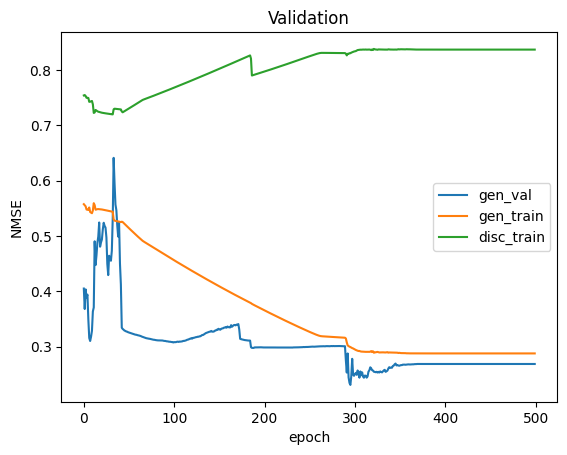

In [43]:
plt.plot(gen_val_loss_track, label='gen_val')
plt.plot(gen_loss_track, label='gen_train')
plt.plot(disc_loss_track, label='disc_train')
plt.xlabel('epoch')
plt.ylabel('NMSE')
plt.title('Validation')
plt.legend()
plt.show()

# For H_equal

In [45]:
# Normalization
H_equal_train_min = H_equal_train.min()
H_equal_train_max = H_equal_train.max()
H_true_train_min = H_true_train.min()
H_true_train_max = H_true_train.max()

H_equal_train_normd = (H_equal_train - H_equal_train_min)/ (H_equal_train_max - H_equal_train_min)
H_true_train_nomrd   = (H_true_train - H_true_train_min)/ (H_true_train_max - H_true_train_min)

H_equal_val_normd   = (H_equal_val - H_equal_train_min)/ (H_equal_train_max - H_equal_train_min)
H_true_val_normd     = (H_true_val - H_true_train_min)/ (H_true_train_max - H_true_train_min)
# for evaluation, output of model(valData) will be de-normalized and compared with valLabels

print(H_equal_val_normd.shape)
print(H_equal_train_normd.shape)

torch.Size([367, 2, 612, 14])
torch.Size([3072, 2, 612, 14])


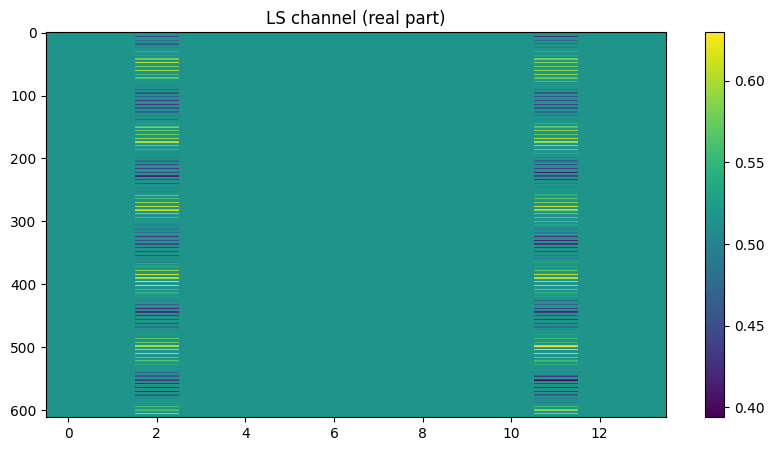

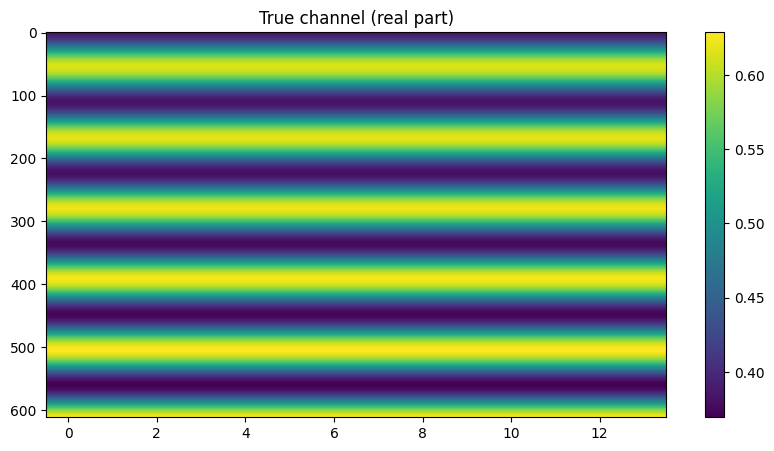

In [50]:
plot = 1
if plot:
    H_temp = H_equal_train_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('LS channel (real part)')
    plt.show()

    H_temp = H_true_train_nomrd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title('True channel (real part)')
    plt.show()

In [47]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((H_equal_train_normd[:,0,:,:], H_equal_train_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((H_true_train_nomrd[:,0,:,:], H_true_train_nomrd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)


In [48]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [6144, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(H_linear_val_normd, H_true_val_normd)  # [367, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [51]:
generator = utils.Generator(in_channel=1)   # in_channel=1 to estimate real and imag parts separately,
                                            # default: in_channel=2 to estimate real and imag parts at the same time
discriminator = utils.Discriminator(in_channel=1)

epoc = 0 # flag
load_saved_model = 0
if load_saved_model:
    # modify the directory
    epoc = 30
    #
    generator_load_path = os.path.join(config.FILE_PATH, 'model/static', 'GAN_'+str(snr)+'dB_epoch_'+str(epoc)+'_generator_'+rowss+'.pth')
    discriminator_load_path = os.path.join(config.FILE_PATH, 'model/static', 'GAN_'+str(snr)+'dB_epoch_'+str(epoc)+'_discriminator_'+rowss+'.pth')
    variable_load_path = os.path.join(config.FILE_PATH, 'model/static', 'GAN_'+str(snr)+'dB_epoch_'+str(epoc)+'_variable_'+rowss+'.pth')
    # load the models
    generator.load_state_dict(torch.load(generator_load_path))
    discriminator.load_state_dict(torch.load(discriminator_load_path))
    var_state = torch.load(variable_load_path)

generator = generator.to(config.device)
discriminator = discriminator.to(config.device)

generator_optimizer = torch.optim.Adam(params= generator.parameters(), lr=2e-4, betas=(0.5, 0.999)) # 2e-4
discriminator_optimizer = torch.optim.RMSprop(params=discriminator.parameters(), lr=2e-5)           # 2e-5

In [52]:
NUM_EPOCHS = 500

if load_saved_model:
    gen_loss_track = var_state['gen_loss_track']
    disc_loss_track = var_state['disc_loss_track']
    gen_val_loss_track = var_state['gen_val_loss_track']
else: 
    gen_loss_track  = []    # BCE loss in training
    disc_loss_track = []    # BCE loss in training
    gen_val_loss_track = [] # MSE _ compare estimated and true channels
    
H_GAN_LS_val = torch.empty_like(H_true_val_normd)
start_time = datetime.datetime.now()
criterion = nn.MSELoss()

for epoch in range(NUM_EPOCHS):
    generator.train()
    discriminator.train()
    running_gen_loss  = 0.0
    running_disc_loss = 0.0
    if (epoch == NUM_EPOCHS-1):
            i = 0
    print("-----\nEPOCH:", epoch)        
    # for bi, (target, input_image) in enumerate(load_image_train(file_path)):
    for bi, (input_image, target) in enumerate(train_loader):
        # input_image == H_inter == Nsamples x 2 x subcs x symb
        # target      == H_Real  == Nsamples x 2 x subcs x symb x 2 x ant
        elapsed_time = datetime.datetime.now() - start_time
        gen_loss, disc_loss = utils.train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer)
        running_gen_loss += gen_loss
        running_disc_loss += disc_loss
        
    avg_train_gen_loss = running_gen_loss / len(train_loader)
    avg_train_disc_loss = running_disc_loss / len(train_loader)
    gen_loss_track.append(avg_train_gen_loss)
    disc_loss_track.append(avg_train_disc_loss)
    print('Generate Loss (BCE Loss in training): ', avg_train_gen_loss)
    print('Discriminate Loss(BCE Loss in training): ', avg_train_disc_loss)
    
    generator.eval()
    running_gen_val_loss  = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = generator(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_gen_val_loss += val_loss_real.item()
            
            val_outputs_imag = generator(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_gen_val_loss += val_loss_imag.item()

            # save the estimated channel at the last epoch 
            # need i because we loop over batch_size
            if (epoch == NUM_EPOCHS-1): 
                H_GAN_LS_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_GAN_LS_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
    
    # MSE of estimated and true channels            
    avg_gen_val_loss = running_gen_val_loss/ (len(val_inputs)*2) # divided by 2 because real and imag parts 
        
    gen_val_loss_track.append(avg_gen_val_loss)
    
    print('MSE of estimated and true channels (normalized): ', avg_gen_val_loss)
            
    # if epoch == epochs-1:
    #     nmse_epoch = TemporaryFile()
    #     nm.cpu()
    #     np.save(nmse_epoch, nm)


-----
EPOCH: 0
Generate Loss (BCE Loss in training):  0.5508936283489069
Discriminate Loss(BCE Loss in training):  0.7533004429812232
MSE of estimated and true channels (normalized):  0.49821314414342244
-----
EPOCH: 1
Generate Loss (BCE Loss in training):  0.548424173767368
Discriminate Loss(BCE Loss in training):  0.7520252518976728
MSE of estimated and true channels (normalized):  0.4922952651977539
-----
EPOCH: 2
Generate Loss (BCE Loss in training):  0.5479014664888382
Discriminate Loss(BCE Loss in training):  0.7513921928281585
MSE of estimated and true channels (normalized):  0.48741498788197835
-----
EPOCH: 3
Generate Loss (BCE Loss in training):  0.5474145129943887
Discriminate Loss(BCE Loss in training):  0.7509695837895075
MSE of estimated and true channels (normalized):  0.472246120373408
-----
EPOCH: 4
Generate Loss (BCE Loss in training):  0.5469030396391948
Discriminate Loss(BCE Loss in training):  0.7507180096581578
MSE of estimated and true channels (normalized):  0.44

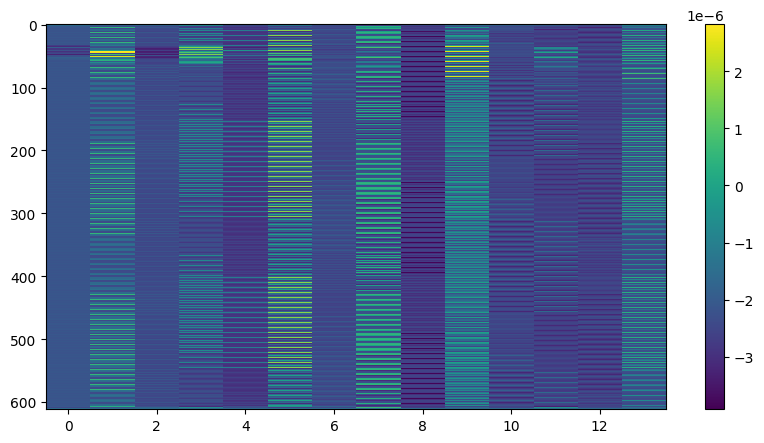

In [58]:
# Linear interpolated channel
H_test1 = H_GAN_LS_val * (H_linear_train_max - H_linear_train_min) + H_linear_train_min
H_test1= H_test1.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_test1[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [59]:
epoc = epoc + NUM_EPOCHS
save_folder = os.path.join(config.FILE_PATH, 'model/static')
generator_save_path = os.path.join(save_folder, 'GAN_LS_'+str(snr)+'dB_epoch_'+str(epoc)+'_generator_'+rowss+'.pth')
discriminator_save_path = os.path.join(save_folder, 'GAN_LS_'+str(snr)+'dB_epoch_'+str(epoc)+'_discriminator_'+rowss+'.pth')
variable_save_path = os.path.join(save_folder, 'GAN_LS_'+str(snr)+'dB_epoch_'+str(epoc)+'_variable_'+rowss+'.pth')

# Save the models' state dictionaries to the specified paths
torch.save(generator.state_dict(), generator_save_path)
torch.save(discriminator.state_dict(), discriminator_save_path)
torch.save({'H_GAN_val': H_test1, 'H_true_val':H_true_val, 'gen_val_loss_track': gen_val_loss_track, 'disc_loss_track': disc_loss_track, 'gen_loss_track':gen_loss_track}, variable_save_path)
            # estimated channel after denormalized                        
                                # true channel before normalized

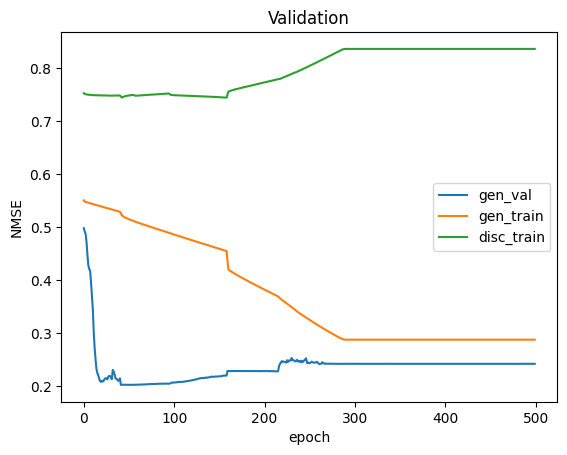

In [55]:
plt.plot(gen_val_loss_track, label='gen_val')
plt.plot(gen_loss_track, label='gen_train')
plt.plot(disc_loss_track, label='disc_train')
plt.xlabel('epoch')
plt.ylabel('NMSE')
plt.title('Validation')
plt.legend()
plt.show()

# To do
$x+1$
- how to get the true channel
- how to get Y (received signal) <---  
- estimate: map-based channel model

In [ ]:
generator.save_weights('saved_model/test/generator_weights.h5')
generator.save('saved_model/test/generator_arch')

In [ ]:
generator.summary()

In [ ]:
discriminator.save_weights('saved_model/test/discriminator_weights.h5')
discriminator.save('saved_model/test/discriminator_arch')

In [ ]:
plt.figure()
plt.plot(np.arange(NUM_EPOCHS), nm, '^-r')
plt.xlabel('Epochs')
plt.ylabel('NMSE')
plt.show()